In [1]:
! pip install langchain langchain-community langchain-openai


     ---------------------------------------- 1.0/1.0 MB 8.0 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 16.1 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 443.9/443.9 kB 9.4 MB/s eta 0:00:00
     ------------------------------------- 360.3/360.3 kB 11.3 MB/s eta 0:00:00
     -------------------------------------- 437.7/437.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 44.4/44.4 kB 2.3 MB/s eta 0:00:00
     ------------------------------------- 442.9/442.9 kB 13.5 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 15.9 MB/s eta 0:00:00
     ------------------------------------- 680.4/680.4 kB 10.8 MB/s eta 0:00:00
     -------------------------------------- 894.0/894.0 kB 8.0 MB/s eta 0:00:00
     -------------------------------------- 120.8/120.8 kB 7.4 MB/s eta 0:00:00
     --------------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.2.5 which is incompatible.


In [31]:
! pip install python-dotenv


In [3]:
! pip install sentence-transformers faiss-cpu langchain huggingface-hub


     -------------------------------------- 345.7/345.7 kB 5.4 MB/s eta 0:00:00
     --------------------------------------- 15.0/15.0 MB 16.8 MB/s eta 0:00:00
     ------------------------------------- 484.3/484.3 kB 10.1 MB/s eta 0:00:00
     --------------------------------------- 11.1/11.1 MB 19.8 MB/s eta 0:00:00
     -------------------------------------- 212.5/212.5 MB 8.7 MB/s eta 0:00:00
     --------------------------------------- 10.4/10.4 MB 16.8 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 13.7 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 19.2 MB/s eta 0:00:00
     -------------------------------------- 308.9/308.9 kB 9.6 MB/s eta 0:00:00
     ---------------------------------------- 2.4/2.4 MB 17.2 MB/s eta 0:00:00
     -------------------------------------- 307.7/307.7 kB 9.6 MB/s eta 0:00:00
     --------------------------------------- 15.8/15.8 MB 18.2 MB/s eta 0:00:00
     ------------------------------------- 

In [4]:
! pip install langchain langchain-experimental


     -------------------------------------- 209.2/209.2 kB 6.2 MB/s eta 0:00:00


In [5]:
! pip install tabulate
! pip install tabulate matplotlib seaborn numpy


In [ ]:
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# .env 読み込み
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")
print(f"username={username}")
print(f"Password={password}")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")
# API URL (FFTをランダムに10件取得)
url = "https://metabase.tr-com.net/api/card/2045/query/json"

# Headers
headers = {
    "Content-Type": "application/json",
    
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "sensorid"]],
            "value": "VC003396"
        }
    ]
}


..\environment\.env
ログイン試行中 → username: 'y-nitta@torishima.co.jp'
username=y-nitta@torishima.co.jp
Password=wo6@2_kmypX>
✅ ログイン成功


In [ ]:

# Make the request
response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(df)
        df2=df.iloc[:,3].str.split(',',expand=True)#FFTデータをdfに
        df2[9999]=df2[9999].str.replace('\r','')
        df2=df2.apply(pd.to_numeric, errors="coerce")

        df3 = df2.iloc[:, :1000]# under1000HZ
        df3.columns = [f"{i}Hz" for i in range(1, 1001)]
        df3.index = pd.to_datetime(df["fftrecord_date"]).dt.date
        

        print(df3)
    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


# =========================
# 🤖 Pandas Agent 設定
# =========================

llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.2,
    max_tokens=500,
)

agent = create_pandas_dataframe_agent(
    llm,
    df3,#どのデータをエージェントに投げるか
    verbose=True,
    allow_dangerous_code=True  
)

# =========================
# 💬 質問関数と会話ループ
# =========================

def ask_question(question: str):
    try:
        response = agent.run(question)
        print(f"👤 {question}")
        print(f"🤖 {response}\n")
    except Exception as e:
        print(f"❌ エラー: {e}")

def talk():
    print("🔁 DataFrame QAエージェント開始（'exit' または '終了' で終了）")
    while True:
        try:
            user_input = input("👤 ")
            if user_input.lower() in ["exit", "終了", "quit"]:
                print("🛑 終了します")
                break
            response = agent.run(user_input)
            print(f"🤖 {response}\n")
        except KeyboardInterrupt:
            print("\n🛑 中断されました。会話を終了します")
            break

# =========================
# ✅ 使用例
# =========================

# ask_question("3列目の最頻値は？")
# talk()
ask_question("何ができる？")




✅ データ取得成功
   sensorid                       UserId       fftrecord_date  \
0  VC003396    Masayuki.Mori@kuraray.com  2025-02-12T05:43:01   
1  VC003396    Masayuki.Mori@kuraray.com  2025-02-19T05:42:36   
2  VC003396  k-kinoshita@torishima.co.jp  2025-03-12T05:41:14   
3  VC003396    Masayuki.Mori@kuraray.com  2025-03-13T07:41:02   
4  VC003396    Masayuki.Mori@kuraray.com  2025-03-19T05:40:46   
5  VC003396    Masayuki.Mori@kuraray.com  2025-03-26T05:40:29   
6  VC003396    Masayuki.Mori@kuraray.com  2025-04-02T05:39:43   
7  VC003396    Masayuki.Mori@kuraray.com  2025-04-09T05:39:11   
8  VC003396    Masayuki.Mori@kuraray.com  2025-04-23T05:38:14   
9  VC003396    Masayuki.Mori@kuraray.com  2025-05-07T05:37:16   

                                            fftdatax  
0  0,0,0,0,0,0,0,0,0,0,0,0.01,0.03,0.03,0.01,0,0,...  
1  0.01,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0,0,0,0...  
2  0.01,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0,0,0,0,0...  
3  0.01,0,0,0,0,0,0,0,0,0,0,0,0.01,0.03,0.01,0,0,...  

In [62]:
ask_question("特徴的なデータを探して（理由も）")




> Entering new AgentExecutor chain...
Thought: 特徴的なデータを探すためには、データフレームの統計的な要約や異常値を確認する必要があります。特に、各列の平均、中央値、最大値、最小値などを確認し、異常に高いまたは低い値を持つ行を特定することが重要です。また、特定の日付におけるデータの傾向を確認することも有用です。

Action: pandasを使ってデータフレームの基本的な統計情報を取得する。
Action Input: df.describe()pandasを使ってデータフレームの基本的な統計情報を取得する。 is not a valid tool, try one of [python_repl_ast].Action: python_repl_ast
Action Input: df.describe()             1Hz   2Hz   3Hz   4Hz   5Hz   6Hz   7Hz   8Hz   9Hz  10Hz  11Hz  \
count  10.000000  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0   
mean    0.008000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
std     0.004216   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
min     0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25%     0.010000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50%     0.010000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
75%     0.010000   0.0   0.0   0.0   0.0   0.0   0.0   

In [59]:
ask_question("60Hzの傾向は？")




> Entering new AgentExecutor chain...
Thought: To analyze the trend of the 60Hz column in the dataframe `df`, I will first extract the data from the 60Hz column and then compute some basic statistics or visualize it to understand its trend over time. I will check the values in the 60Hz column to see how they change over the dates provided in the `fftrecord_date` column.

Action: I will extract the 60Hz column and display its values along with the corresponding dates.
Action Input: `df[['fftrecord_date', '60Hz']]`I will extract the 60Hz column and display its values along with the corresponding dates. is not a valid tool, try one of [python_repl_ast].To analyze the trend of the 60Hz column in the dataframe `df`, I will extract the data from the 60Hz column and compute some basic statistics or visualize it to understand its trend over time. I will check the values in the 60Hz column to see how they change over the dates provided in the `fftrecord_date` column.

Action: I will extract t

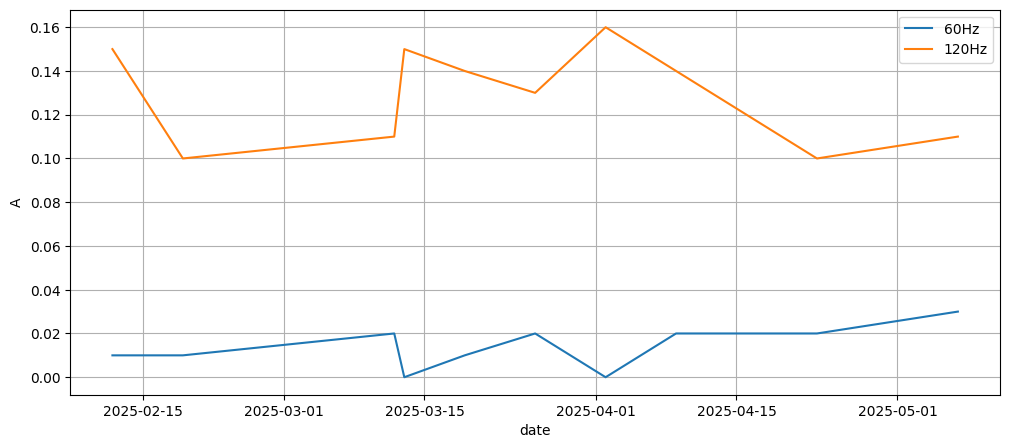

In [ ]:
import matplotlib.pyplot as plt
df3[["60Hz", "120Hz"]].plot(figsize=(12, 5))

plt.ylabel("A")
plt.xlabel("date")
plt.grid(True)
plt.show()
#####